# Setup

In [ ]:
%pip install torch-geometric
%pip install pynvml

In [52]:
import os
import math
import time
import psutil
import pynvml
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as nn_utils
import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_absolute_error

from scipy.spatial.distance import jensenshannon
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(42)

using cpu


# Data Preprocessing

In [28]:
dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
# dataset_path = '/notebooks/dataset/'


def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
    num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            adj_matrix = graph_dataset[i, t, :, :]
            num_edges = np.sum(adj_matrix > 0)
            if num_edges == 0:
                is_valid = False
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

def split_data(adj_data, features_data, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, random_seed=None):
    assert adj_data.shape[0] == features_data.shape[0], "Adjacency and features data must have the same number of samples"
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "The sum of train, val and test ratios must be 1"

    num_samples = adj_data.shape[0]
    indices = np.arange(num_samples)
    if random_seed is not None:
        np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_end = int(train_ratio * num_samples)
    val_end = train_end + int(val_ratio * num_samples)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    adj_train = torch.tensor(adj_data[train_indices], dtype=torch.float32)
    adj_val = torch.tensor(adj_data[val_indices], dtype=torch.float32)
    adj_test = torch.tensor(adj_data[test_indices], dtype=torch.float32)

    features_train = torch.tensor(features_data[train_indices], dtype=torch.float32)
    features_val = torch.tensor(features_data[val_indices], dtype=torch.float32)
    features_test = torch.tensor(features_data[test_indices], dtype=torch.float32)

    return adj_train, adj_val, adj_test, features_train, features_val, features_test


In [29]:
## Simulated Dataset
simulated_adj = np.load(dataset_path + 'simulated_adj.npy')
simulated_adj = simulated_adj[:, :, :, :,0] #only take the domain 1
simulated_features = np.load(dataset_path + 'simulated_laplacian_features.npy')
simulated_features = simulated_features[:, :, :, :,0]
simulated_num_samples, simulated_num_time, simulated_num_nodes, simulated_num_features = simulated_features.shape 
print(f'Simulated Dataset: Number of Samples= {simulated_num_samples},  Number of Times= {simulated_num_time}, Number of Nodes= {simulated_num_nodes}, Number of Features= {simulated_num_features}')
simulated_adj_train, simulated_adj_val, simulated_adj_test, simulated_features_train, simulated_features_val, simulated_features_test = split_data(simulated_adj, simulated_features)

## EMCI-AD Dataset
emci = np.load(dataset_path + 'emci-ad_adj.npy')
emci_cleaned = data_cleansing(emci)
emci_adj = check_and_drop_invalid_graphs(emci_cleaned)
emci_features = np.load(dataset_path + 'emci-ad_laplacian_features.npy') 
emci_num_samples, emci_num_time, emci_num_nodes, emci_num_features = emci_features.shape 
print(f'EMCI-AD Dataset: Number of Samples= {emci_num_samples},  Number of Times= {emci_num_time}, Number of Nodes= {emci_num_nodes}, Number of Features= {emci_num_features}')
emci_adj_train, emci_adj_val, emci_adj_test, emci_features_train, emci_features_val, emci_features_test = split_data(emci_adj, emci_features)

## SLIM160 Dataset
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim160_cleaned = data_cleansing(slim160)
slim160_adj = check_and_drop_invalid_graphs(slim160_cleaned)
slim160_features = np.load(dataset_path + 'slim160_laplacian_features_8.npy') 
slim160_num_samples, slim160_num_time, slim160_num_nodes, slim160_num_features = slim160_features.shape 
print(f'SLIM160 Dataset: Number of Samples= {slim160_num_samples},  Number of Times= {slim160_num_time}, Number of Nodes = {slim160_num_nodes}, Number of Features = {slim160_num_features}')
slim160_adj_train, slim160_adj_val, slim160_adj_test, slim160_features_train, slim160_features_val, slim160_features_test = split_data(slim160_adj, slim160_features)

Simulated Dataset: Number of Samples= 100,  Number of Times= 3, Number of Nodes= 35, Number of Features= 8
EMCI-AD Dataset: Number of Samples= 67,  Number of Times= 2, Number of Nodes= 35, Number of Features= 8
SLIM160 Dataset: Number of Samples= 109,  Number of Times= 3, Number of Nodes = 160, Number of Features = 8


# Models

In [96]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_nodes):
        super(GCNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.gcn1 = GCN(self.input_dim, self.hidden_dim)
        self.bn1 = nn.BatchNorm1d(self.hidden_dim)
        self.gcn2 = GCN(self.hidden_dim, self.latent_dim)
        self.bn2 = nn.BatchNorm1d(self.latent_dim)
        
        self.fc = nn.Linear(self.latent_dim * num_nodes, self.latent_dim)

    def forward(self, x, adj):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = F.dropout(x, training=self.training)
        x_flat = x.view(-1)
        z = self.fc(x_flat)
        
        return z

class GCNDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_nodes):
        super(GCNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        
        self.fc = nn.Linear(self.latent_dim,  self.num_nodes * self.latent_dim)
        self.bn0 = nn.BatchNorm1d(self.latent_dim)

        self.gcn1 = GCN(self.latent_dim, self.hidden_dim)
        self.bn1 = nn.BatchNorm1d(self.hidden_dim)
        self.gcn2 = GCN(self.hidden_dim, self.num_nodes)
        self.bn2 = nn.BatchNorm1d(self.num_nodes)


    def forward(self, z):
        x = self.bn0(self.fc(z).view(self.num_nodes, self.latent_dim))
        adj = torch.eye(self.num_nodes, device=z.device)
        
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))

        adj_pred = (x + x.t()) / 2
        adj_pred = adj_pred - torch.diag(torch.diag(adj_pred))
        return adj_pred

class RidgeLayer(nn.Module):
    def __init__(self, in_features, out_features, alpha=1):
        super(RidgeLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.alpha = alpha

    def forward(self, x):
        return self.linear(x)

    def ridge_regularization(self):
        return self.alpha * torch.sum(self.linear.weight ** 2)

class GCESNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_nodes, 
                leaky_rate=1, num_iterations=1, ridge_alpha1=0.9, ridge_alpha2=0.7):
        super(GCESNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.spectral_radius = 0.9
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.ridge_layer_1 = RidgeLayer(self.hidden_dim, self.latent_dim, ridge_alpha1)
        # self.ridge_layer_2 = RidgeLayer(self.latent_dim, self.latent_dim, ridge_alpha2)
        
        self.fc = nn.Linear(self.latent_dim * num_nodes, self.latent_dim)

    def initialize_weights(self):
        self.Win_1 = nn.Parameter(torch.rand((self.input_dim, self.hidden_dim)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_dim, self.hidden_dim)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((self.latent_dim, self.latent_dim)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

    def forward(self, x, adj):
        h = torch.mm(x, self.Win_1)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.ridge_layer_1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        # h = self.ridge_layer_2(h)

        h_flat = h.view(-1)
        z = self.fc(h_flat)
        return z

class GCESNDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_nodes,
                leaky_rate=1, num_iterations=1, ridge_alpha1=0.9, ridge_alpha2=0.7):
        super(GCESNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_features = hidden_dim
        self.num_nodes = num_nodes
        
        self.fc = nn.Linear(self.latent_dim,  self.num_nodes * self.latent_dim)
        self.bn0 = nn.BatchNorm1d(self.latent_dim)

        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.ridge_layer_1 = RidgeLayer(self.latent_dim, self.hidden_features, ridge_alpha1)
        self.ridge_layer_2 = RidgeLayer(self.hidden_features, self.num_nodes, ridge_alpha2)
        
    def initialize_weights(self):
        self.W_1 = nn.Parameter(torch.rand((self.latent_dim, self.latent_dim)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

    def forward(self, z):
        h = self.bn0(self.fc(z).view(self.num_nodes, self.latent_dim))
        adj = torch.eye(self.num_nodes, device=z.device)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.ridge_layer_1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.ridge_layer_2(h)

        adj_pred = (h + h.t()) / 2
        adj_pred = adj_pred - torch.diag(torch.diag(adj_pred))
        return adj_pred

In [94]:
class GCNTransformer(nn.Module):
    def __init__(self, num_nodes, input_dim, latent_dim, encoder_hidden_dims, decoder_hidden_dims):
        super(GCNTransformer, self).__init__()
        self.encoder = GCNEncoder(input_dim, encoder_hidden_dims, latent_dim, num_nodes)
        self.decoder = GCNDecoder(latent_dim, decoder_hidden_dims, num_nodes)  

    def forward(self, x, adj):
        # Encoding
        z = self.encoder(x, adj)
        
        # Decoding
        adj_pred = self.decoder(z)
        
        return adj_pred, z
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

                
class GCESNTransformer(nn.Module):
    def __init__(self, num_nodes, input_dim, latent_dim, 
                encoder_hidden_dims, encoder_leaky_rate, encoder_iteration,
                decoder_hidden_dims, decoder_leaky_rate, decoder_iteration):
        super(GCESNTransformer, self).__init__()
        self.encoder = GCESNEncoder(input_dim, encoder_hidden_dims, latent_dim, num_nodes, 
                                    encoder_leaky_rate, encoder_iteration)
        self.decoder = GCESNDecoder(latent_dim, decoder_hidden_dims, num_nodes,
                                    decoder_leaky_rate, decoder_iteration)  
    
    def initialize_weights(self):
        self.encoder.initialize_weights()
        self.decoder.initialize_weights() 

    def forward(self, x, adj):
        # Encoding
        z = self.encoder(x, adj)
        
        # Decoding
        adj_pred = self.decoder(z)
        
        return adj_pred, z
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [69]:
def loss_function(recon_adj, adj, lambda_1=1.0, lambda_2=1.0):
    # Generative loss
    gen_loss = F.l1_loss(recon_adj, adj, reduction='sum')
    
    # Topological loss
    node_strength_recon = torch.sum(recon_adj, dim=1)
    node_strength_gt = torch.sum(adj, dim=1)
    top_loss = F.mse_loss(node_strength_recon, node_strength_gt, reduction='sum')
    
    # Total loss
    loss = (lambda_1 * gen_loss) + (lambda_2 * top_loss)
    return loss, gen_loss, top_loss

# Trainings & Evaluations

In [26]:
## Single Functions
def train(model, train_features, train_adj, val_features, val_adj, 
                lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.1, 
                lambda_1=1.0, lambda_2=1.0, save_path='models/gcn_transformer_x.pth'):

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    training_loss = []
    validation_loss = []

    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)
    process = psutil.Process()

    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_gen_loss = 0
        epoch_top_loss = 0

        val_loss = 0
        val_gen_loss = 0
        val_top_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for i in range(train_features.size(0)):
            for t in range(train_features.size(1) - 1):
                optimizer.zero_grad()
                
                x_t = train_features[i, t].to(device)
                adj_t = train_adj[i, t].to(device)
                adj_t_next = train_adj[i, t+1].to(device)
                
                recon_adj, z = model(x_t, adj_t)
                loss, gen_loss, top_loss = loss_function(recon_adj, adj_t_next, lambda_1, lambda_2)
                loss.backward()
                
                nn_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
                
                optimizer.step()
                epoch_loss += loss.item()
                epoch_gen_loss += gen_loss.item()
                epoch_top_loss += top_loss.item()
        
        scheduler.step()  

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        
        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        epoch_loss /= (train_features.size(0) * (train_features.size(1) - 1))
        epoch_gen_loss /= (train_features.size(0) * (train_features.size(1) - 1))
        epoch_top_loss /= (train_features.size(0) * (train_features.size(1) - 1))
        
        training_loss.append(epoch_loss)
        print(f'Epoch {epoch + 1}\n  Training -> Loss: {epoch_loss:.4f}, Generative Loss: {epoch_gen_loss:.4f}, Topological Loss: {epoch_top_loss:.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in range(val_features.size(0)):
                for t in range(val_features.size(1) - 1):
                    x_t = val_features[i, t].to(device)
                    adj_t = val_adj[i, t].to(device)
                    adj_t_next = val_adj[i, t+1].to(device)
                    
                    recon_adj, z = model(x_t, adj_t)
                    loss, gen_loss, top_loss = loss_function(recon_adj, adj_t_next, lambda_1, lambda_2)
                    
                    val_loss += loss.item()
                    val_gen_loss += gen_loss.item()
                    val_top_loss += top_loss.item()
            
            val_loss /= (val_features.size(0) * (val_features.size(1) - 1))
            val_gen_loss /= (val_features.size(0) * (val_features.size(1) - 1))
            val_top_loss /= (val_features.size(0) * (val_features.size(1) - 1))
        
            validation_loss.append(val_loss)
            print(f'  Validation -> Loss: {val_loss:.4f}, Generative Loss: {val_gen_loss:.4f}, Topological Loss: {val_top_loss:.4f}')

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                total_epoch = epoch + 1
                break
        
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage_percent[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}GB, GPU: {gpu_usage[-1]:.2f}GB, GPU Util: {gpu_usage_percent[-1]:.2f}%')

    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(save_path))
    print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_memory_usage = np.max(memory_usage)
    max_gpu_usage = np.max(gpu_usage)
    max_gpu_usage_percent = np.max(gpu_usage_percent)

    print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    print(f'Average CPU Usage: {avg_cpu_usage_percent:.2f}%')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'Average GPU Usage: {avg_gpu_usage:.2f}GB')
    print(f'Average GPU Utilization: {avg_gpu_usage_percent:.2f}%')

    print(f'\nTotal Training Time: {total_training_time:.2f}s')
    print(f'Max CPU Usage: {max_cpu_usage_percent:.2f}%')
    print(f'Max Memory Usage: {max_memory_usage:.2f}GB')
    print(f'Max GPU Usage: {max_gpu_usage:.2f}GB')
    print(f'Max GPU Utilization: {max_gpu_usage_percent:.2f}%')

    return


In [49]:
# Define plot_heatmaps function if not already defined
def plot_heatmaps_each_timepoint(input_adj, ground_truth_adj, reconstructed_adj, residual_adj, time_point):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Input Graph at Time {time_point}')

    ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Ground Truth Graph at Time {time_point+1}')

    ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Generated Graph at Time {time_point+1}')

    ax[3].imshow(residual_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[3].set_title(f'Residual Graph at Time {time_point+1}')

    plt.show()

def plot_heatmaps_across_timepoints(input_adj, ground_truth_adj, reconstructed_adj, time_point):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    cax0 = ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Graph at Time {time_point}')
    fig.colorbar(cax0, ax=ax[0])

    cax1 = ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Graph at Time {time_point+1}')
    fig.colorbar(cax1, ax=ax[1])

    cax2 = ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Residual Graph between Time {time_point} and {time_point+1}')
    fig.colorbar(cax2, ax=ax[2])

    plt.show()

def inference_model(model, x, adj, sample_idx=0):
    # Load the saved model
    model.eval()

    # Perform inference
    with torch.no_grad():
        # Generate graph at time point 1 given graph at time point 0
        recon_adj_1, _ = model(x[sample_idx, 0], adj[sample_idx, 0])
        residual_adj_1 = recon_adj_1 - adj[sample_idx, 1]
        plot_heatmaps_each_timepoint(adj[sample_idx, 0], adj[sample_idx, 1], recon_adj_1, residual_adj_1, 0)

        # Generate graph at time point 2 given graph at time point 1
        recon_adj_2, _ = model(x[sample_idx, 1], adj[sample_idx, 1])
        residual_adj_2 = recon_adj_2 - adj[sample_idx, 2]
        plot_heatmaps_each_timepoint(adj[sample_idx, 1], adj[sample_idx, 2], recon_adj_2, residual_adj_2, 1)

        # Plot residual graph between the output of the first time point and the second time point
        residual_between_gt = adj[sample_idx, 2] - adj[sample_idx, 1]
        mse_residual_between_gt = np.mean(np.square(residual_between_gt.cpu().detach().numpy()))
        print("Mean Squared Error between ground truth graphs: ", mse_residual_between_gt)
        plot_heatmaps_across_timepoints(adj[sample_idx, 1], adj[sample_idx, 2], residual_between_gt, 1)

        residual_between_outputs = recon_adj_2 - recon_adj_1
        mse_residual_between_outputs = np.mean(np.square(residual_between_outputs.cpu().detach().numpy()))
        print("Mean Squared Error between generated graphs: ", mse_residual_between_outputs)
        plot_heatmaps_across_timepoints(recon_adj_1, recon_adj_2, residual_between_outputs, 1)

def vectorize(M):
    return M[np.tril_indices(M.shape[0], k=-1)]
    
def evaluate_model(model, x_test, adj_test):
    num_test_samples = x_test.shape[0]
    num_roi = adj_test.shape[2]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    with torch.no_grad():
        for i in range(num_test_samples):
            for t in range(1, x_test.shape[1]):
                set_seed(42)
                x_t = x_test[i, t-1]  # Node features at time point t-1
                adj_t = adj_test[i, t-1]  # Adjacency matrix at time point t-1
                
                recon_adj_t, _= model(x_t, adj_t)
                pred_matrices_all.append(recon_adj_t.cpu().numpy())
                
                adj_t_gt = adj_test[i, t]  
                gt_matrices_all.append(adj_t_gt.cpu().numpy())
                
                pred_1d_list.append(vectorize(recon_adj_t.cpu().numpy()))
                gt_1d_list.append(vectorize(adj_t_gt.cpu().numpy()))


    for i in range(len(pred_matrices_all)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(recon_adj_t.cpu().numpy())
        gt_graph = nx.from_numpy_array(adj_t_gt.cpu().numpy())

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())

        # Compute MAEs
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

                
    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)

    return

## GCN

#### Simulated

GCNTransformer(
  (encoder): GCNEncoder(
    (gcn1): GCN (8 -> 16)
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gcn2): GCN (16 -> 32)
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Linear(in_features=1120, out_features=32, bias=True)
  )
  (decoder): GCNDecoder(
    (fc): Linear(in_features=32, out_features=1120, bias=True)
    (bn0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gcn1): GCN (32 -> 16)
    (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gcn2): GCN (16 -> 35)
    (bn2): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Total number of trainable parameters: 74905

Epoch 1
  Training -> Loss: 3660.1193237304688, Generative Loss: 392.0843281337193, Topological Loss: 3268.034992327009
  Validation -> Loss: 4694.903283691407, Generative Loss: 411.016767883

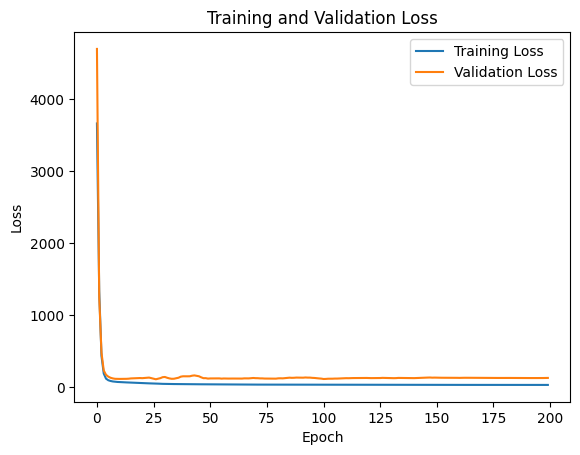

Model saved to models/gcntransformer_simulated.pth
Average Time per Epoch: 0.55s
Average CPU Usage: 26.38%
Average Memory Usage: 0.06GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 109.09s
Max CPU Usage: 67.45%
Max Memory Usage: 0.08GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%


In [88]:
set_seed(42)
gcntransformer_simulated = GCNTransformer(simulated_num_nodes, simulated_num_features, 
                                        latent_dim=32, encoder_hidden_dims=16, decoder_hidden_dims=16)
print(gcntransformer_simulated)
print(f"Total number of trainable parameters: {(gcntransformer_simulated.count_parameters())}\n")

train(gcntransformer_simulated, simulated_features_train.to(device), simulated_adj_train.to(device),  
    simulated_features_val.to(device), simulated_adj_val.to(device), lr=0.0001, num_epochs=200, 
    patience=5, step_size=50, gamma=0.5, save_path='models/gcntransformer_simulated.pth')

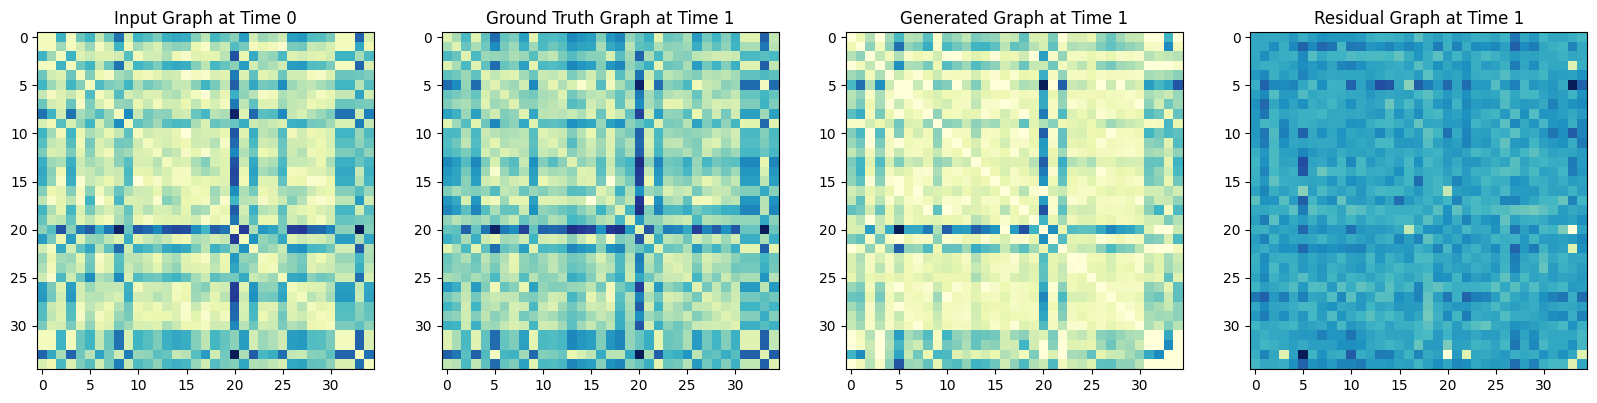

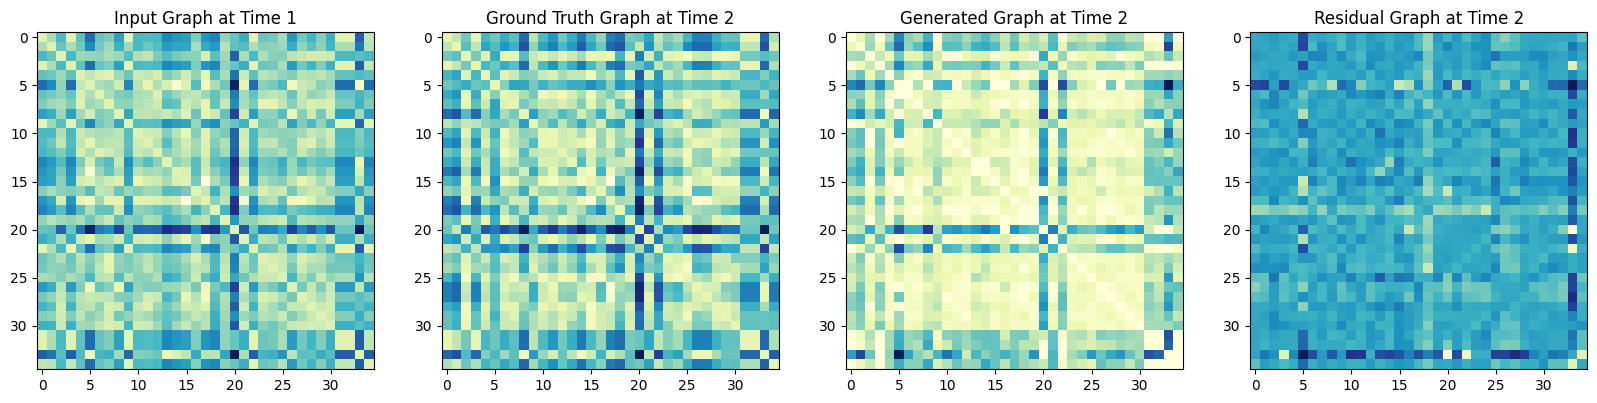

Mean Squared Error between ground truth graphs:  0.0023131445


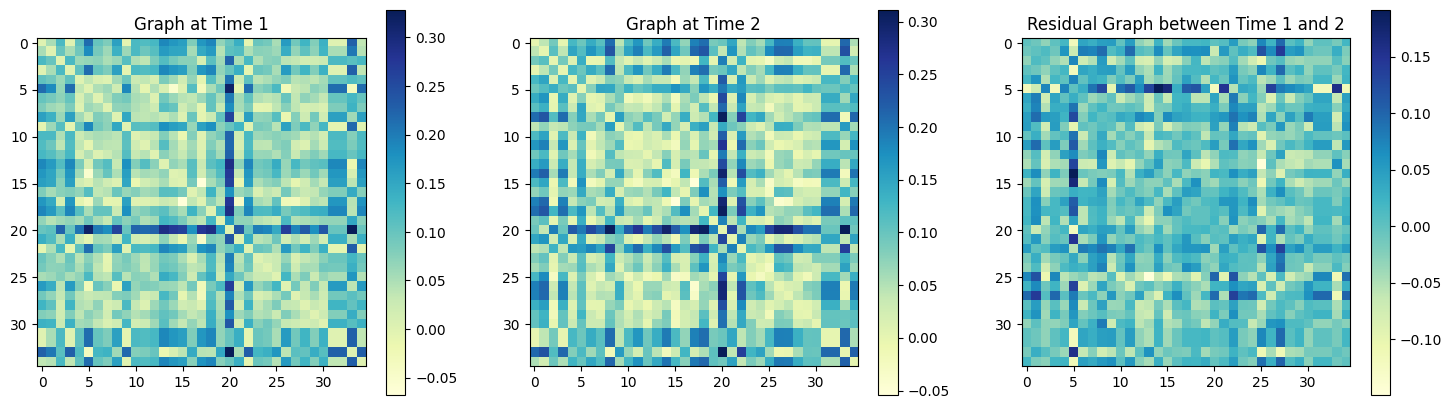

Mean Squared Error between generated graphs:  0.0010460139


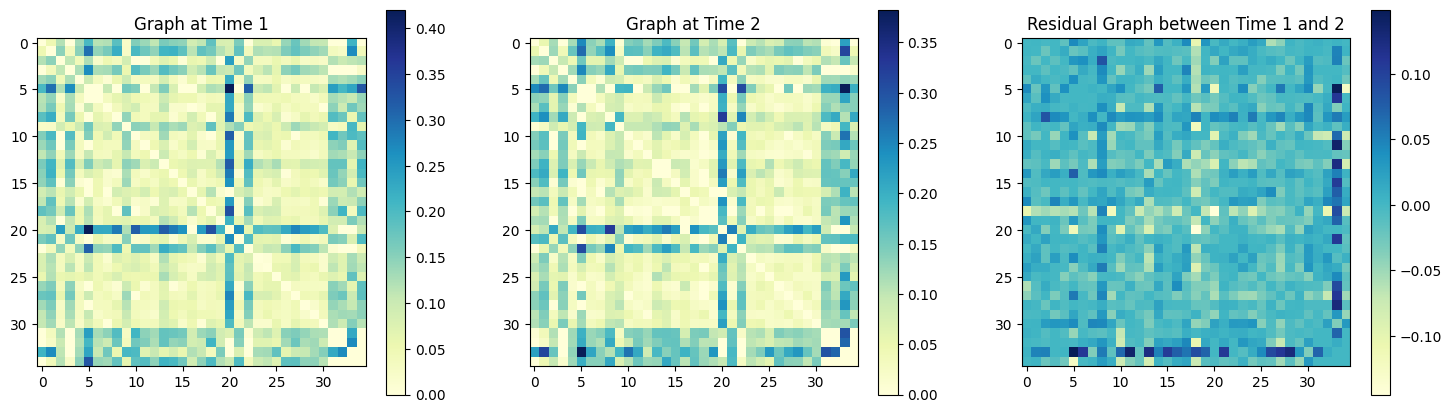

In [80]:
inference_model(gcntransformer_simulated, simulated_features_test.to(device), simulated_adj_test.to(device), sample_idx=1)

In [81]:
evaluate_model(gcntransformer_simulated, simulated_features_test.to(device), simulated_adj_test.to(device))

MAE:  0.05141929
Jensen-Shannon Distance:  inf
Average MAE betweenness centrality: 0.2032085561497326
Average MAE eigenvector centrality: 0.04975567418783112
Average MAE PageRank centrality: 0.0076998169595123515


#### EMCI-AD

#### SLIM160

## GCESN

#### Simulated

GCESNTransformer(
  (encoder): GCESNEncoder(
    (ridge_layer_1): RidgeLayer(
      (linear): Linear(in_features=16, out_features=32, bias=True)
    )
    (fc): Linear(in_features=1120, out_features=32, bias=True)
  )
  (decoder): GCESNDecoder(
    (fc): Linear(in_features=32, out_features=1120, bias=True)
    (bn0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ridge_layer_1): RidgeLayer(
      (linear): Linear(in_features=32, out_features=16, bias=True)
    )
    (ridge_layer_2): RidgeLayer(
      (linear): Linear(in_features=16, out_features=35, bias=True)
    )
  )
)
Total number of trainable parameters: 74563

Epoch 1
  Training -> Loss: 716.5939915248326, Generative Loss: 147.39751641409737, Topological Loss: 569.196474129813
  Validation -> Loss: 566.3184631347656, Generative Loss: 134.44013290405275, Topological Loss: 431.8783233642578
Time: 0.34s, CPU: 22.80%, Memory: 0.07GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 2
  Training -> Loss: 402.59

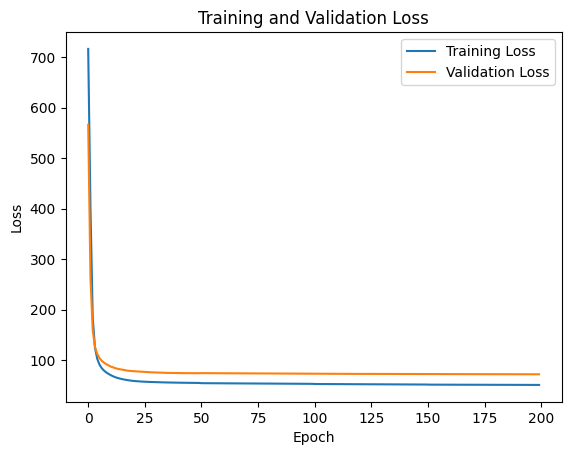

Model saved to models/gcesn_transformer_simulated.pth
Average Time per Epoch: 0.32s
Average CPU Usage: 16.56%
Average Memory Usage: 0.07GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 63.49s
Max CPU Usage: 60.90%
Max Memory Usage: 0.09GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%


In [97]:
set_seed(42)
gcesn_transformer_simulated = GCESNTransformer(simulated_num_nodes, simulated_num_features, latent_dim=32, 
                                        encoder_hidden_dims=16, encoder_leaky_rate=0.9, encoder_iteration=2,
                                        decoder_hidden_dims=16, decoder_leaky_rate=0.9, decoder_iteration=2)
gcesn_transformer_simulated.initialize_weights()
print(gcesn_transformer_simulated)
print(f"Total number of trainable parameters: {(gcesn_transformer_simulated.count_parameters())}\n")

train(gcesn_transformer_simulated, simulated_features_train.to(device), simulated_adj_train.to(device),  
    simulated_features_val.to(device), simulated_adj_val.to(device), lr=0.0001, num_epochs=200, 
    patience=5, step_size=50, gamma=0.5, save_path='models/gcesn_transformer_simulated.pth')

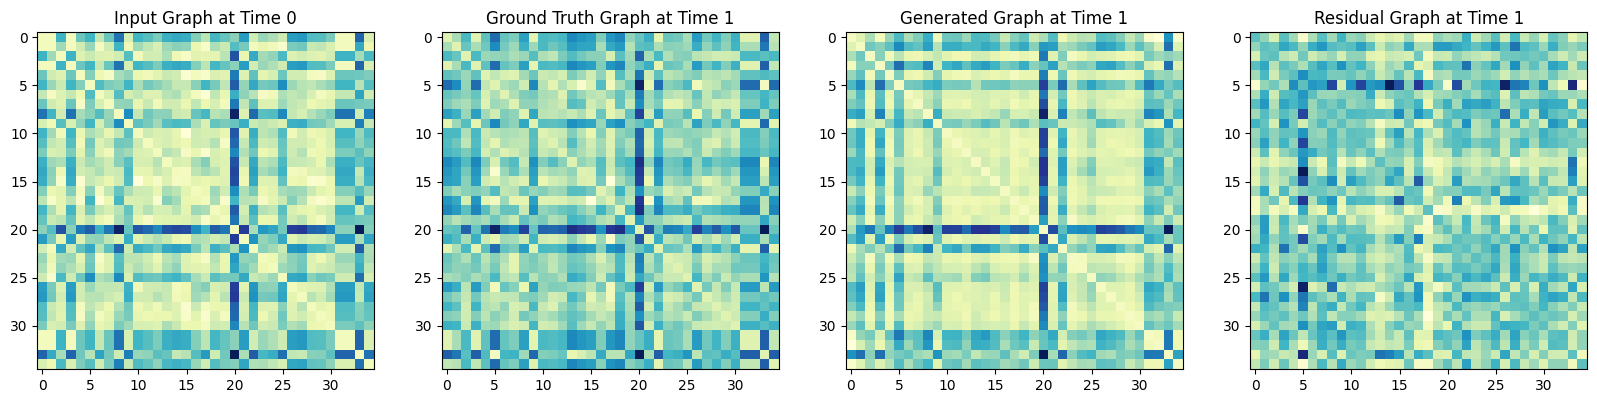

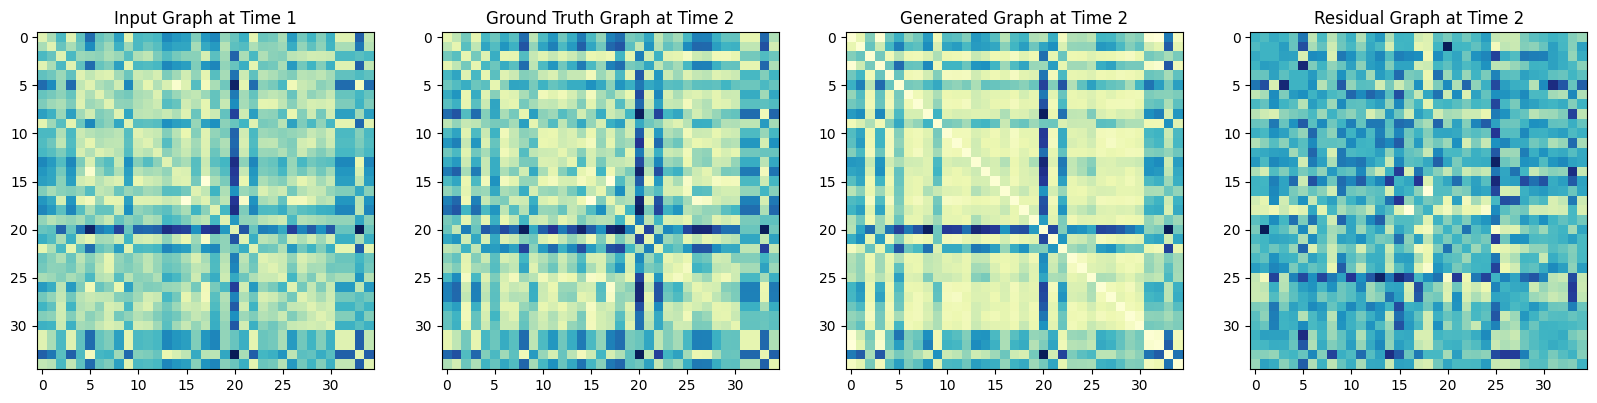

Mean Squared Error between ground truth graphs:  0.0023131445


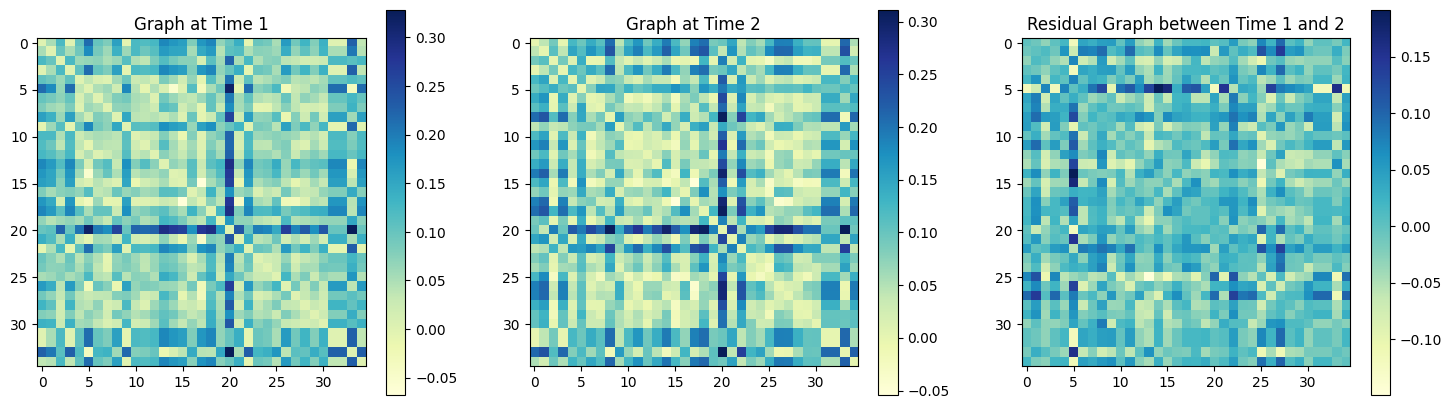

Mean Squared Error between generated graphs:  0.0003269415


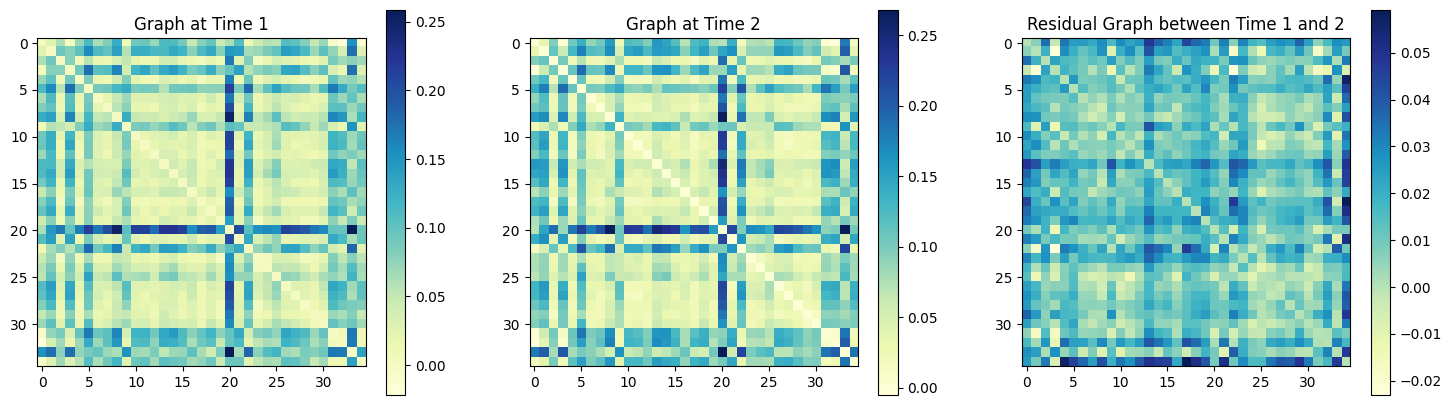

In [98]:
inference_model(gcesn_transformer_simulated, simulated_features_test.to(device), simulated_adj_test.to(device), sample_idx=1)

In [100]:
evaluate_model(gcesn_transformer_simulated, simulated_features_test.to(device), simulated_adj_test.to(device))

MAE:  0.036125623
Jensen-Shannon Distance:  inf
Average MAE betweenness centrality: 0.18966131907308365
Average MAE eigenvector centrality: 0.025137414181875185
Average MAE PageRank centrality: 0.004509044970683967


#### EMCI-AD

#### SLIM160